In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from typing import List
from tqdm import tqdm

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
import shap

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

# Helpers

In [2]:
def value_counts(df:pd.DataFrame, columns:List[str], normalize:bool=True, sort_index:bool=False, dropna=True):
    res = df[columns].value_counts(dropna=dropna).to_frame(name="counts")
    if normalize:
        tmp = df[columns].value_counts(dropna=dropna, normalize=True).to_frame(name="percents") * 100
        res = res.merge(tmp, on=columns)
    if sort_index:
        res = res.sort_index()
    return res

In [3]:
def plot_roc_curve(model, dfx_train, dfx_valid, features, target):
    fig, ax = plt.subplots(figsize=(6, 5))
    metrics.RocCurveDisplay.from_estimator(model, dfx_train[features], dfx_train[target], ax=ax, name="Train ROC Curve")
    metrics.RocCurveDisplay.from_estimator(model, dfx_valid[features], dfx_valid[target], ax=ax, name="Valid ROC Curve")
    plt.legend()
    plt.show()

In [4]:
def grid_search(X, y, param_grid, cv=5, random_state=42):
    """
    Perform grid search for LightGBM classifier on given X, y using AUC as metric.
    Returns the best parameters dictionary.
    """
    lgb_clf = LGBMClassifier(random_state=random_state)
    grid = GridSearchCV(
        estimator=lgb_clf,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X, y)
    return grid.best_params_

In [5]:
def find_best_threshold(y_true, y_score, metric='f1'):
    best_score = -np.inf
    best_thresh = 0.5
    thresholds = np.arange(0.01, 1.0, 0.01)

    for thresh in thresholds:
        y_pred = (y_score >= thresh).astype(int)
        if metric == 'precision':
            score = metrics.precision_score(y_true, y_pred)
        elif metric == 'recall':
            score = metrics.recall_score(y_true, y_pred)
        elif metric == 'f1':
            score = metrics.f1_score(y_true, y_pred)
        elif metric == 'accuracy':
            score = metrics.accuracy_score(y_true, y_pred)
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score

In [6]:
def plot_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Default', 'Default'])
    disp.plot(cmap=plt.cm.Greens, ax=ax, values_format='d')
    
    cm_normalized = cm.astype('float') / np.full((2, 2), cm.sum())
    # Overlay percentages as annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = cm_normalized[i, j] * 100
            ax.text(j, i + 0.2, f'{percentage:.1f}%', ha='center', va='center', color='red', fontsize=12)
    plt.title('Confusion Matrix')
    plt.show()

# Load data and overview

In [7]:
df = pd.read_csv("../data/Loan_default.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


# Train

## Define features

In [8]:
features = [
    'Age', 'Income', 'LoanAmount', 'CreditScore',
    'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
    'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'
]

cat_features = [
    'Education', 'EmploymentType', 'MaritalStatus',
    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'
]

target = "Default"
print("# features =", len(features))
print("# categorical features =", len(cat_features))

# features = 16
# categorical features = 7


In [9]:
df[cat_features] = df[cat_features].astype(str).astype("category")

## Split data

In [10]:
df_train, df_test = train_test_split(df, stratify=df[target], test_size=0.2, random_state=42)

In [11]:
value_counts(df_train, target)

,counts,percents
Default,,
0,180555,88.39
1,23722,11.61


In [12]:
value_counts(df_test, target)

,counts,percents
Default,,
0,45139,88.39
1,5931,11.61


## Train baseline model
- No tuning

In [14]:
params = dict(
    objective='binary', metric='AUC', boosting='gbdt', 
    learning_rate=0.1, max_depth=5, bagging_fraction=1.0, feature_fraction=1.0,
    num_boost_round=2000, early_stopping_rounds=200, seed=42, verbose=-1, n_jobs=-1
)

dfx_train, dfx_valid = train_test_split(df_train, stratify=df_train[target], test_size=0.2, random_state=42)

model = LGBMClassifier(**params)
model.fit(
    dfx_train[features], dfx_train[target], 
    eval_set=[(dfx_valid[features], dfx_valid[target])], 
    eval_metric=params["metric"]
)

LGBMClassifier(bagging_fraction=1.0, boosting='gbdt', early_stopping_rounds=200,
               feature_fraction=1.0, max_depth=5, metric='AUC', n_jobs=-1,
               num_boost_round=2000, objective='binary', seed=42, verbose=-1)

In [15]:
model.best_iteration_

92

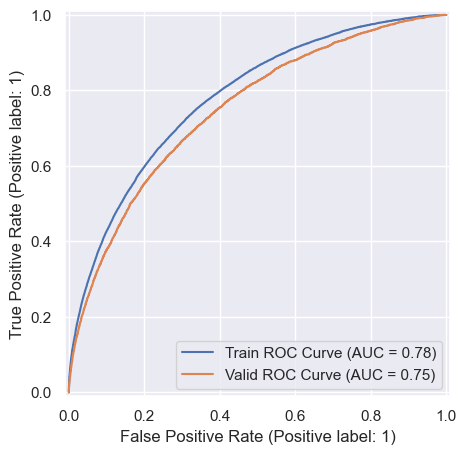

In [17]:
plot_roc_curve(model, dfx_train, dfx_valid, features, target)

## Grid Search
- Fine-tune parameters to improve baseline

In [35]:
%%time
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [90, 100, 500],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0, 5],
    'reg_lambda': [0, 5],
    'verbose': [-1]
}

best_params = grid_search(df_train[features], df_train[target], param_grid)
best_params

Fitting 5 folds for each of 96 candidates, totalling 480 fits
CPU times: user 6.89 s, sys: 4.15 s, total: 11 s
Wall time: 9min 57s


{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 500,
 'num_leaves': 31,
 'reg_alpha': 5,
 'reg_lambda': 0,
 'subsample': 0.5,
 'verbose': -1}

## Train final models

In [11]:
best_params = dict(
    objective='binary', metric='AUC', boosting='gbdt', 
    learning_rate=0.05, max_depth=3, bagging_fraction=.5, feature_fraction=.5,
    num_leaves=31, reg_alpha=5, reg_lambda=0,
    num_boost_round=500, early_stopping_rounds=100, seed=42, verbose=-1, n_jobs=-1
)

In [12]:
models = []
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_idx, valid_idx) in enumerate(tqdm(cv.split(df_train, df_train[target]))):
    dfx_train = df.iloc[train_idx].reset_index(drop=True)
    dfx_valid = df.iloc[valid_idx].reset_index(drop=True)

    model = LGBMClassifier(**best_params)
    model.fit(
        dfx_train[features], dfx_train[target], 
        eval_set=[(dfx_valid[features], dfx_valid[target])], 
        eval_metric=best_params["metric"]
    )
    models.append(model)

5it [00:06,  1.23s/it]


In [13]:
pd.DataFrame([
    {
        "fold": i + 1,
        "num_iteration": model.best_iteration_,
        "AUC": metrics.roc_auc_score(df_train[target], model.booster_.predict(df_train[features]))
    } for i, model in enumerate(models)
])

,fold,num_iteration,AUC
0,1,392,0.76
1,2,479,0.76
2,3,500,0.76
3,4,336,0.76
4,5,481,0.76


In [24]:
# plot_roc_curve(models[-1], dfx_train, dfx_valid, features, target)

## Choose threshold

In [14]:
thres_list = []
for i, (_, valid_idx) in enumerate(tqdm(cv.split(df_train, df_train[target]))):
    dfx_valid = df.iloc[valid_idx].reset_index(drop=True)
    y_true = dfx_valid[target]
    y_score = models[i].booster_.predict(dfx_valid[features])
    best_thresh, best_score = find_best_threshold(y_true, y_score, metric='f1')
    thres_list.append({
        "fold": i + 1,
        "best_threshold": best_thresh,
        "best_f1_score": best_score,
        "precision": metrics.precision_score(y_true, (y_score >= best_thresh).astype(int)),
        "recall": metrics.recall_score(y_true, (y_score >= best_thresh).astype(int)),
        "accuracy": metrics.accuracy_score(y_true, (y_score >= best_thresh).astype(int))
    })

5it [00:01,  4.42it/s]


In [15]:
pd.DataFrame(thres_list)

,fold,best_threshold,best_f1_score,precision,recall,accuracy
0,1,0.17,0.37,0.29,0.52,0.79
1,2,0.18,0.38,0.30,0.49,0.81
2,3,0.18,0.36,0.29,0.48,0.81
3,4,0.17,0.37,0.29,0.52,0.80
4,5,0.18,0.37,0.29,0.50,0.80


In [16]:
best_threshold = np.round(np.mean([x["best_threshold"] for x in thres_list]), 3)
best_threshold

np.float64(0.176)

# Test

In [17]:
y_score = np.mean([
    model.booster_.predict(df_test[features])
    for model in models
], axis=0)

y_pred = (y_score >= best_threshold).astype(int)
y_true = df_test[target]

AUC score = 0.7668833827434602


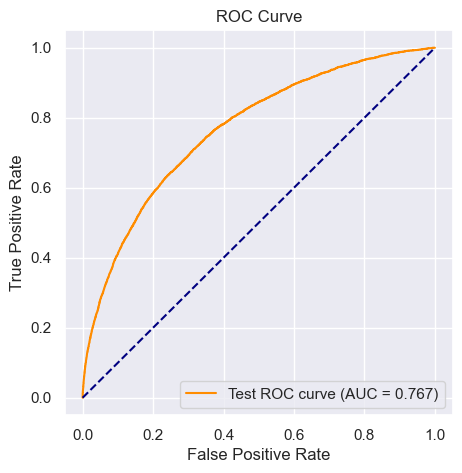

In [26]:
# ROC Curve and AUC

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
roc_auc = metrics.auc(fpr, tpr)
print("AUC score =", roc_auc)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', label=f"Test ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.savefig("roc_curve_test.png")
plt.show()

In [27]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88     45139
           1       0.30      0.52      0.38      5931

    accuracy                           0.80     51070
   macro avg       0.62      0.68      0.63     51070
weighted avg       0.86      0.80      0.83     51070



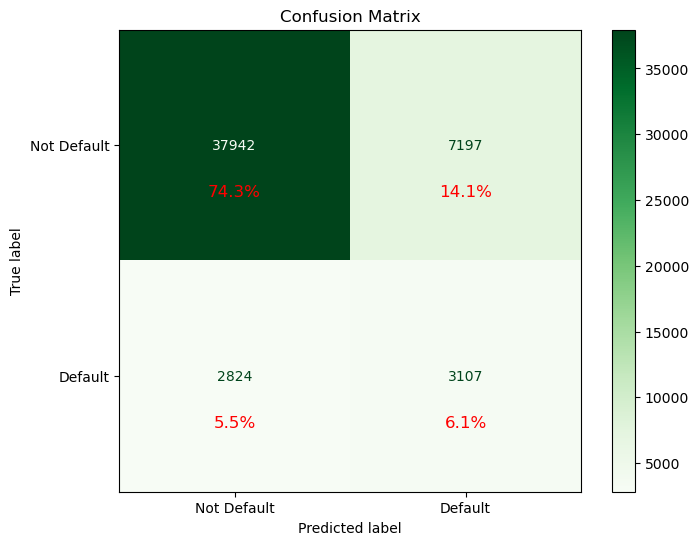

In [18]:
# cm = metrics.confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.savefig("confusion_matrix_test.png")
# plt.show()

plot_confusion_matrix(y_true, y_pred)

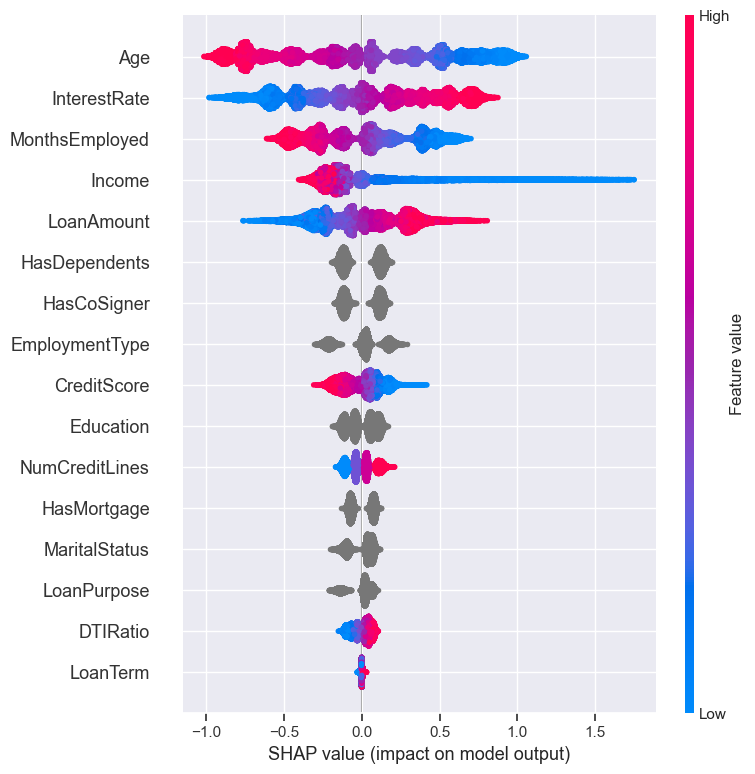

In [76]:
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(df_test[features])
shap.summary_plot(shap_values, df_test[features], plot_type="dot")

# Save model

In [150]:
for i, m in enumerate(models):
    m.booster_.save_model(f"../models/v2025-11-27/model_{i}.booster")